elapsed time for fitting is
1072.623134613037


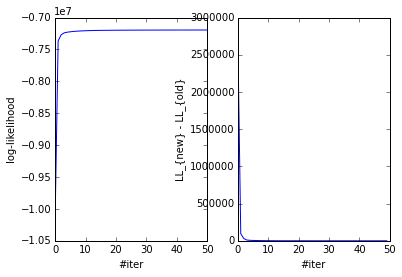

In [1]:
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt

import ssm_timeSeries as ts  # my self-written time series overhead
import ssm_fit               # my self-written library for state-space model fitting
import ssm_scripts

import random
from datetime import datetime     # generate random seed for 
random.seed(datetime.now())       # np.random. Once this is fixed, all 
rngSeed = random.randint(0, 1000) # other 'randomness' is also fixed

%matplotlib inline


""" Set problem size """

yDim = 60
xDim = 5
uDim = 0

T = 100000
Trial = 1


""" Generate some sensible parameters that give a learnable problem """
A = np.diag(np.linspace(0.9,0.98,xDim))
Q = np.identity(xDim)
Pi = np.array([sp.linalg.solve_discrete_lyapunov(A, Q)])[0,:,:]
            
V0 = Pi
mu0 = np.zeros(xDim)

C = np.random.normal(size=[yDim, xDim])    
CPiC = np.dot(C, np.dot(Pi, C.transpose()))
R = (0.25 + np.random.uniform(size=[yDim])) * CPiC.diagonal() 
CPiCR = CPiC + np.diag(R)    

d = np.sqrt(np.mean(np.diag(CPiCR))) * np.random.normal(size=yDim)

B = np.zeros([])

%matplotlib inline
plt.subplot(2,2,1)
plt.imshow(A, interpolation='none')
plt.subplot(2,2,2)
plt.plot(np.diag(Pi))    

plt.subplot(2,2,3)
plt.imshow(CPiCR, interpolation='none')
plt.subplot(2,2,4)
plt.plot(np.sort(np.diag(CPiCR)))

trueParameters = {'A' : A,
                  'B' : B,
                  'Q' : Q,
                'mu0' : mu0,
                 'V0' : V0,
                  'C' : C,
                  'd' : d,
                  'R' : R }

""" Set observation protocol """

#subpops = [list(range(0,yDim)), list(range(0,yDim))]
#obsTime = [int(T/2), T]
#obsPops = [1,0]

subpops = [[], list(range(0,35)), list(range(30,yDim))]
obsPops = []
obsTime = []

tempStitchOrder = 5
for t in range(1,int(T/2)+1):
    obsTime.append(t)
    if np.mod(t,tempStitchOrder)==0:
        obsPops.append(1)
    else:
        obsPops.append(0)
tempStitchOrder = 3
for t in range(int(T/2)+2,T+1):
    obsTime.append(t)
    if np.mod(t,tempStitchOrder)==0:
        obsPops.append(2)
    else:
        obsPops.append(0)        
        
    
obsScheme = {'subpops': subpops,
             'obsTime': obsTime,
             'obsPops': obsPops}

fitOptions = {'ifUseB' : False,  
              'maxIter': 50, 
              'ifPlotProgress' : True,
              'covConvEps' : 0,
              'ifTraceParamHist': False
             }

""" Fit the model, save results """

sf = '/home/mackelab/Desktop/Projects/Stitching/results/test_problems/LDS_save.mat'
[yOut,xOut,u,learnedPars,initPars,truePars] = ssm_scripts.run(xDim, yDim, uDim, T, 
                                                              obsScheme, fitOptions,
                                                              truePars=trueParameters,
                                                              saveFile=sf)



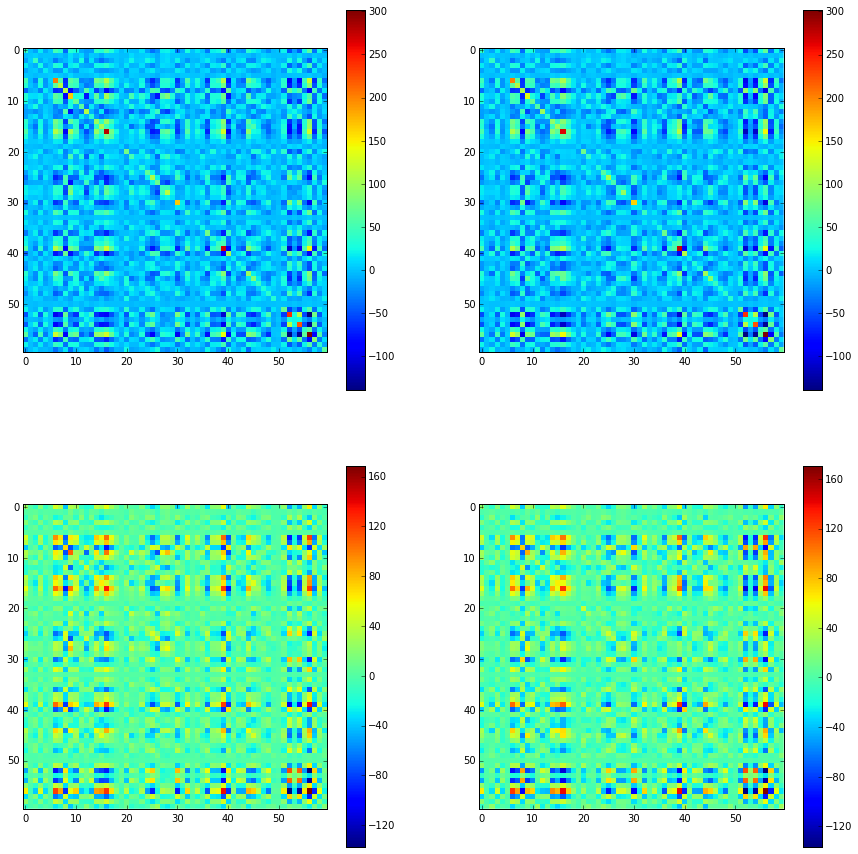

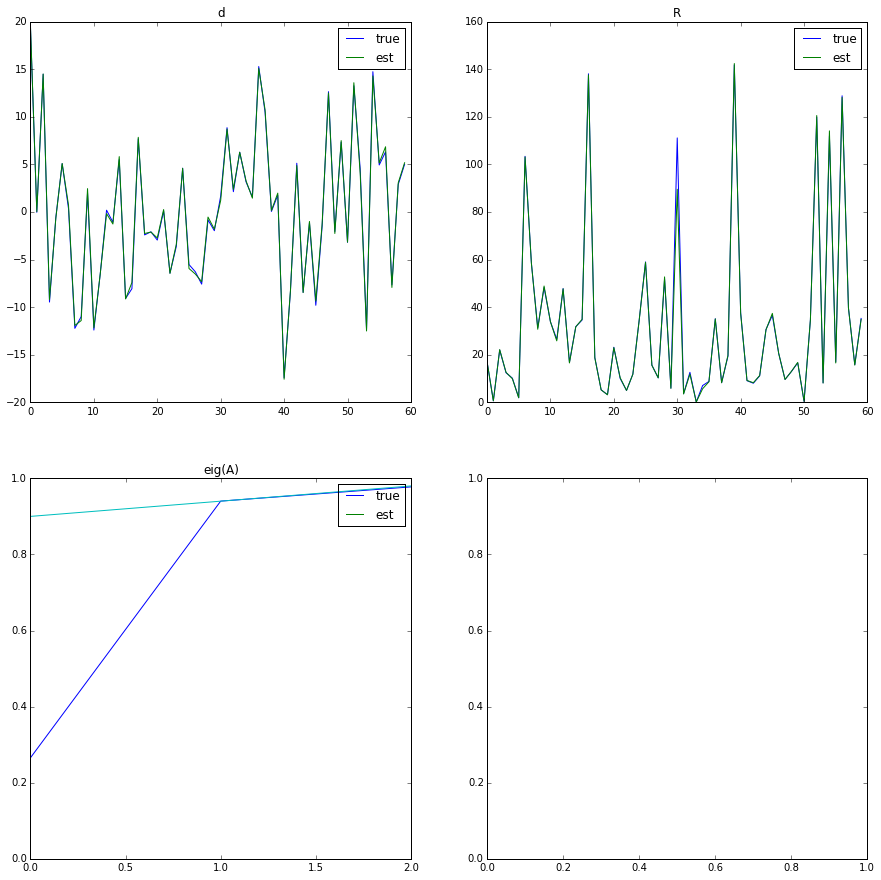

In [2]:
[A,B,Q,mu0,V0,C,d,R] = learnedPars 
Pi    = np.array([sp.linalg.solve_discrete_lyapunov(A, Q)])[0,:,:]

plt.figure(1,figsize=(15,15))
plt.subplot(2,2,1)
plt.imshow(np.dot(np.dot(C, Pi), C.transpose()) + np.diag(R), interpolation='none')
plt.colorbar()
plt.subplot(2,2,2)
Pi_true = np.array([sp.linalg.solve_discrete_lyapunov(trueParameters['A'], trueParameters['Q'])])[0,:,:]
plt.imshow(np.dot(np.dot(trueParameters['C'],Pi_true),trueParameters['C'].transpose()) +
           np.diag(trueParameters['R']),
           interpolation='none')
plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(np.dot(np.dot(np.dot(C, A), Pi), C.transpose()), interpolation='none' )
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(np.dot(np.dot(np.dot(trueParameters['C'], trueParameters['A']), Pi_true), 
                                trueParameters['C'].transpose()), 
          interpolation='none' )
plt.colorbar()

plt.figure(2,figsize=(15,15))
plt.subplot(2,2,1)
plt.plot(d)
plt.plot(trueParameters['d'])
plt.legend(['true', 'est'])
plt.title('d')
plt.subplot(2,2,2)
plt.plot(R)
plt.plot(trueParameters['R'])
plt.legend(['true', 'est'])
plt.title('R')
plt.subplot(2,2,3)
plt.plot(np.sort(np.linalg.eig(A)[0]))
plt.plot(np.sort(np.diag(np.linalg.eig(trueParameters['A'])[0])))
plt.legend(['true', 'est'])
plt.title('eig(A)')
plt.subplot(2,2,4)
